<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Start/SaveLoad/Classify_EuroSAT_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Assignment

## Saving and loading models, with application to the EuroSat dataset

### Instructions

In this notebook, you will create a neural network that classifies land uses and land covers from satellite imagery. You will save your model using Tensorflow's callbacks and reload it later. You will also load in a pre-trained neural network classifier and compare performance with it. 

Some code cells are provided for you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Retrieve the image files
os.makedirs('./data', exist_ok=True)
os.makedirs('./models', exist_ok=True)

In [ ]:
%%bash
cp -rf ./drive/MyDrive/Tutorial/data ./data
cp -rf ./drive/MyDrive/Tutorial/models ./models

In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu tensorflow_hub
pip check

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. 
# Do not make any imports elsewhere in the notebook.
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

# If you would like to make further imports from tensorflow, 
# add them here

![EuroSAT overview image](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/image/eurosat/eurosat_overview.jpg?raw=1)

#### The EuroSAT dataset

In this assignment, you will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake. For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

Your goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some of the saving and loading techniques you have learned in the previous sessions.

#### Import the data

The dataset you will train your model on is a subset of the total data, with 4000 training images and 1000 testing images, with roughly equal numbers of each class. The code to import the data is provided below.

In [2]:
# Run this cell to import the Eurosat data
def load_eurosat_data():
    data_dir = './data'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_eurosat_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (4000, 64, 64, 3)
y_train shape:  (4000, 1)
x_test shape:  (1000, 64, 64, 3)
y_test shape:  (1000, 1)


#### Build the neural network model

You can now construct a model to fit to the data. Using the Sequential API, build your model according to the following specifications:

* The model should use the input_shape in the function argument to set the input size in the first layer.
* The first layer should be a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_1'.
* The second layer should also be a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_2'.
* The third layer should be a MaxPooling2D layer with a pooling window size of 8x8. Name this layer 'pool_1'.
* The fourth layer should be a Flatten layer, named 'flatten'.
* The fifth layer should be a Dense layer with 32 units, a ReLU activation. Name this layer 'dense_1'.
* The sixth and final layer should be a Dense layer with 10 units and softmax activation. Name this layer 'dense_2'.

In total, the network should have 6 layers.

In [3]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_new_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. 
    Ensure the weights are initialised by providing the input_shape argument in the 
    first layer, given by the function argument.
    Your function should also compile the model with the Adam optimiser, 
    sparse categorical cross entropy loss function, and a single accuracy metric.
    """
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3),
            activation='relu', padding='SAME', name='conv_1',
            input_shape=input_shape),
        tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3),
            activation='relu', padding='SAME', name='conv_2'),
        tf.keras.layers.MaxPooling2D(pool_size=(8, 8), name='pool_1'),
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(units=32, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

#### Compile and evaluate the model

In [4]:
# Run your function to create the model and print the model summary

model = get_new_model(x_train[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 8, 8, 8)           0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 18,354
Trainable params: 18,354
Non-traina

In [5]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(
        x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [6]:
# Calculate its initialised test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.111


#### Create checkpoints to save model during training, with a criterion

You will now create three callbacks:
- `checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training
- `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy. Use the testing data as the validation data.
- `early_stopping`: early stopping object that ends training if the validation accuracy has not improved in 3 epochs.

In [7]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function names or arguments.

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside 
      the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, 
      e.g. 001, 002, 003, etc.
    """
    
    checkpoint_every_epoch_path = \
        "checkpoints_every_epoch/checkpoint_{epoch:03d}"

    return tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_every_epoch_path,
        save_freq='epoch', save_weights_only=True, verbose=2)

def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside
      the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    
    checkpoint_best_only_path = "checkpoints_best_only/checkpoint"

    return tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_best_only_path, 
        save_freq='epoch', save_weights_only=True, save_best_only=True,
        monitor='val_sparse_categorical_accuracy',  verbose=2)

In [8]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy', patience=3)

In [9]:
# Run this cell to create the callbacks

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]

#### Train model using the callbacks

Now, you will train the model using the three callbacks you created. If you created the callbacks correctly, three things should happen:
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_every_epoch`
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_best_only` **only** if those weights lead to the highest test accuracy
- Training stops when the testing accuracy has not improved in three epochs.

You should then have two directories:
- A directory called `checkpoints_every_epoch` containing filenames that include `checkpoint_001`, `checkpoint_002`, etc with the `001`, `002` corresponding to the epoch
- A directory called `checkpoints_best_only` containing filenames that include `checkpoint`, which contain only the weights leading to the highest testing accuracy

In [10]:
class PlotHistory():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)

    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics

    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows, ncols=cls.plt_ncols,
            figsize=cls.plt_figsize)

    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history,
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}', label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()


Epoch 1: saving model to checkpoints_every_epoch/checkpoint_001

Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.31400, saving model to checkpoints_best_only/checkpoint

Epoch 2: saving model to checkpoints_every_epoch/checkpoint_002

Epoch 2: val_sparse_categorical_accuracy improved from 0.31400 to 0.39000, saving model to checkpoints_best_only/checkpoint

Epoch 3: saving model to checkpoints_every_epoch/checkpoint_003

Epoch 3: val_sparse_categorical_accuracy improved from 0.39000 to 0.45500, saving model to checkpoints_best_only/checkpoint

Epoch 4: saving model to checkpoints_every_epoch/checkpoint_004

Epoch 4: val_sparse_categorical_accuracy improved from 0.45500 to 0.45900, saving model to checkpoints_best_only/checkpoint

Epoch 5: saving model to checkpoints_every_epoch/checkpoint_005

Epoch 5: val_sparse_categorical_accuracy improved from 0.45900 to 0.49900, saving model to checkpoints_best_only/checkpoint

Epoch 6: saving model to checkpoints_every_epoch/che

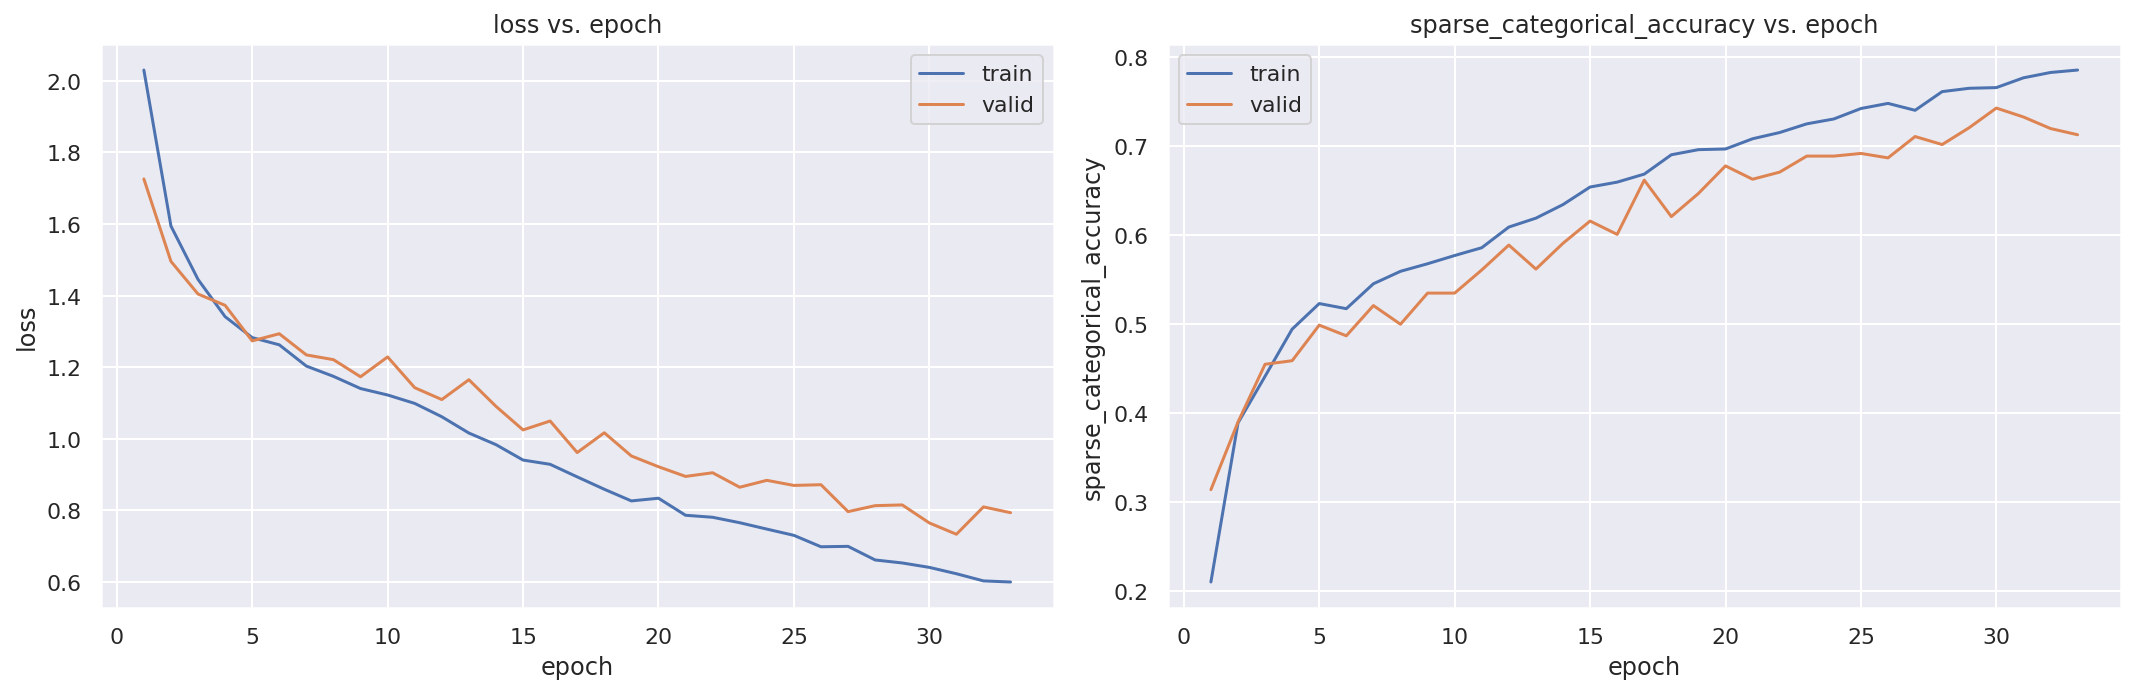

In [11]:
# Train model using the callbacks you just created

history = model.fit(x=x_train, y=y_train, epochs=50, 
    validation_data=(x_test, y_test), callbacks=callbacks, verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'sparse_categorical_accuracy'])\
  .plot()

#### Create new instance of model and load on both sets of weights

Now you will use the weights you just saved in a fresh model. You should create two functions, both of which take a freshly instantiated model instance:
- `model_last_epoch` should contain the weights from the latest saved epoch
- `model_best_epoch` should contain the weights from the saved epoch with the highest testing accuracy

_Hint: use the_ `tf.train.latest_checkpoint` _function to get the filename of the latest saved checkpoint file. Check the docs_ [_here_](https://www.tensorflow.org/api_docs/python/tf/train/latest_checkpoint).

In [12]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_model_last_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier,
    load on the weights from the last training epoch, and return this model.
    """
    
    model.load_weights(
        tf.train.latest_checkpoint(
            checkpoint_dir="./checkpoints_every_epoch"))
    
    return model
    
def get_model_best_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier, 
    load on the weights leading to the highest validation accuracy, and return
    this model.
    """
    
    model.load_weights(
        tf.train.latest_checkpoint(
            checkpoint_dir="./checkpoints_best_only"))
    
    return model

In [13]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one with the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(
    get_new_model(x_train[0].shape))

print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, x_test, y_test)
print('')

model_best_epoch = get_model_best_epoch(
    get_new_model(x_train[0].shape))

print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch, x_test, y_test)

Model with last epoch weights:
accuracy: 0.713

Model with best epoch weights:
accuracy: 0.743


#### Load, from scratch, a model trained on the EuroSat dataset.

In your workspace, you will find another model trained on the `EuroSAT` dataset in `.h5` format. This model is trained on a larger subset of the EuroSAT dataset and has a more complex architecture. The path to the model is `models/EuroSatNet.h5`. See how its testing accuracy compares to your model!

In [ ]:
os.makedirs('./models', exist_ok=True)

In [ ]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_model_eurosatnet():
    """
    This function should return the pretrained EuroSatNet.h5 model.
    """
    model = load_model('./models/EuroSatNet.h5')
    return model

In [ ]:
# Run this cell to print a summary of the EuroSatNet model, 
# along with its validation accuracy.

model_eurosatnet = get_model_eurosatnet()
model_eurosatnet.summary()
get_test_accuracy(model_eurosatnet, x_test, y_test)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 16)        6416      
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 16)        0         
                                                                 
 conv_3 (Conv2D)             (None, 32, 32, 16)        2320      
                                                                 
 conv_4 (Conv2D)             (None, 32, 32, 16)        6416      
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 16)        0         
                                                                 
 conv_5 (Conv2D)             (None, 16, 16, 16)      

In [ ]:
%%bash
# Clear directory
rm -rf checkpoints_every_epoch checkpoints_best_only
rm -rf data models

Congratulations for completing this programming assignment! You're now ready to move on to the capstone project for this course.